# Load the deap data 
### Points to be noted 
used valence 5.05 for thresholding for equal class distribution

In [1]:
import numpy as np
import os
import pickle

# Constants
NUM_SUBJECTS = 32
NUM_TRIALS = 40
NUM_CHANNELS = 32
SAMPLE_LENGTH = 1280  # Extract first 10 seconds at 128Hz
FS  = 128
# Paths
DATA_PATH = "/kaggle/input/deap-dataset/data_preprocessed_python"  # Adjust path as needed

# Initialize storage
all_eeg_data = []
all_labels = []
all_labels_arousal = []

# Helper to load .dat files
def load_dat_file(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f, encoding="latin1")

# Loop through all subjects
for subject in range(1, NUM_SUBJECTS + 1):
    print(f"Processing Subject {subject:02d}...")
    
    filename = f"s{subject:02d}.dat"
    subject_data = load_dat_file(os.path.join(DATA_PATH, filename))
    
    eeg_data = subject_data["data"]  # Shape: (40, 40 channels, 8064)
    labels = subject_data["labels"]  # Shape: (40, 4) => valence, arousal, etc.
    
    for trial in range(NUM_TRIALS):
        # Take the first 1280 samples from each of 32 channels
        trial_data = eeg_data[trial, :NUM_CHANNELS, FS * 3:FS * 63]  # Shape: (32, 1280)
        all_eeg_data.append(trial_data)
        
        # Optionally, you can choose one label (e.g., valence) or convert to 3-class label
        valence = labels[trial][0]  # [0]=valence, [1]=arousal, etc.
        arousal = labels[trial][1]
        # Convert valence into 3 classes: low (0–3.5), medium (3.5–6.5), high (6.5–9)
        if valence < 5.05:
            label = 0
        else:
            label = 1

        all_labels.append(label)

        if arousal < 5.15:
            labela = 0
        else:
            labela = 1

        all_labels_arousal.append(labela)
# Convert to numpy arrays
all_eeg_data = np.array(all_eeg_data)  # Shape: (1280, 32, 1280)
all_labels = np.array(all_labels)      # Shape: (1280,)
all_labels_arousal = np.array(all_labels_arousal) 

# Summary
print("Final EEG shape:", all_eeg_data.shape)
print("Final label shape Valence:", all_labels.shape)
print("Final label shape Arousal:", all_labels_arousal.shape)
print("Label distribution Valence :", np.bincount(all_labels))
print("Label distribution Arousal:", np.bincount(all_labels_arousal))

Processing Subject 01...
Processing Subject 02...
Processing Subject 03...
Processing Subject 04...
Processing Subject 05...
Processing Subject 06...
Processing Subject 07...
Processing Subject 08...
Processing Subject 09...
Processing Subject 10...
Processing Subject 11...
Processing Subject 12...
Processing Subject 13...
Processing Subject 14...
Processing Subject 15...
Processing Subject 16...
Processing Subject 17...
Processing Subject 18...
Processing Subject 19...
Processing Subject 20...
Processing Subject 21...
Processing Subject 22...
Processing Subject 23...
Processing Subject 24...
Processing Subject 25...
Processing Subject 26...
Processing Subject 27...
Processing Subject 28...
Processing Subject 29...
Processing Subject 30...
Processing Subject 31...
Processing Subject 32...
Final EEG shape: (1280, 32, 7680)
Final label shape Valence: (1280,)
Final label shape Arousal: (1280,)
Label distribution Valence : [642 638]
Label distribution Arousal: [635 645]


In [2]:
import numpy as np
import pywt

from scipy.signal import hilbert

# Assuming all_eeg_data is shaped (1280, 32, 7680)
def compute_hilbert_spectrum_energy(eeg_data):
    """
    Computes the Hilbert Spectrum Energy (HSE) for the EEG data
    """
    # Apply Hilbert transform along the time axis
    analytic_signal = hilbert(eeg_data, axis=-1)
    
    # Instantaneous amplitude (magnitude of analytic signal)
    amplitude_envelope = np.abs(analytic_signal)

    # Hilbert Spectrum Energy = square of amplitude
    hse = np.square(amplitude_envelope)

    return hse
#de_feature_data = compute_wavelet_de(all_eeg_data)
#print("Wavelet DE shape:", de_feature_data.shape)  # ✅ (1280, 32, 7680)
# Compute HSE
hse_repeat  = compute_hilbert_spectrum_energy(all_eeg_data)  # ✅ (1280, 32, 7680)
hse_scalar = np.mean(hse_repeat, axis=-1, keepdims=True)  # shape: (1280, 32, 1)
hse_data = np.repeat(hse_scalar, 7680, axis=-1)        # shape: (1280, 32, 7680)

#hse_data = compute_hilbert_spectrum_energy(all_eeg_data)

# Check shape of the HSE data
print("Hilbert Spectrum Energy shape:", hse_data.shape)  # Expected: (1280, 32, 7680)

# Normalize the HSE data (shape: 1280 samples × 32 features × 7680 time points)
x_min = hse_data.min(axis=(1, 2), keepdims=True)
x_max = hse_data.max(axis=(1, 2), keepdims=True)
hse_normal = (hse_data - x_min) / (x_max - x_min + 1e-8)  # Add small epsilon to avoid division by zero

print("Normalized HSE shape:", hse_normal.shape)  # Expected: (1280, 32, 7680)

# Parameters for segmentation
depth = 128  # Temporal segment length (128 samples per segment)
samples = hse_normal.shape[0]  # 1280 samples
features = hse_normal.shape[1]  # 32 features (channels)
time_points = hse_normal.shape[2]  # 7680 time points
segments = time_points // depth  # 7680 / 128 = 60 segments

# Reshape the data into temporal segments
reshaped_hse = hse_normal.reshape(samples, features, segments, depth)

# Map the 32 features into an 8x8 spatial grid at the last step
def eeg_to_spatiotemporal(eeg_trial, channel_map, time_len):
    """
    Converts EEG data to a spatiotemporal format using an 8x8 grid mapping
    eeg_trial: shape (32, time_len)
    channel_map: shape (8, 8)
    returns: shape (8, 8, time_len)
    """
    spatial_grid = np.zeros((8, 8, time_len))
    
    for i in range(8):
        for j in range(8):
            ch = channel_map[i, j]
            if ch != -1:
                spatial_grid[i, j, :] = eeg_trial[ch]
    
    return spatial_grid

# Create a channel map for DEAP's 32 channels into an 8x8 grid
channel_map = np.array([
    [ 0,  1,  2,  3,  4,  5,  6,  7],
    [ 8,  9, 10, 11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20, 21, 22, 23],
    [24, 25, 26, 27, 28, 29, 30, 31],
    [-1, -1, -1, -1, -1, -1, -1, -1],  # Remaining positions are unused (padded)
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1],
])

# Now map the features into spatial grid at the last step
spatiotemporal_hse = np.zeros((samples, segments, 8, 8, depth))

# Reshape and map to spatiotemporal format
for i in range(samples):
    for j in range(segments):
        spatiotemporal_hse[i, j] = eeg_to_spatiotemporal(reshaped_hse[i, :, j, :], channel_map, depth)

# Final shape after mapping to spatiotemporal grid
print("Spatiotemporal HSE shape:", spatiotemporal_hse.shape)  # Expected: (1280, 60, 8, 8, 128)

# Reshape the spatiotemporal HSE segments
final_hse_input = spatiotemporal_hse.reshape(-1, 8, 8, 128)  # (76800, 8, 8, 128)
print("Final HSE input shape:", final_hse_input.shape)


Hilbert Spectrum Energy shape: (1280, 32, 7680)
Normalized HSE shape: (1280, 32, 7680)
Spatiotemporal HSE shape: (1280, 60, 8, 8, 128)
Final HSE input shape: (76800, 8, 8, 128)


In [3]:


repeated_labels = np.repeat(all_labels, 60)  # Shape: (76800,)
print("Repeated label shape:", repeated_labels.shape)


repeated_labels_arousal = np.repeat(all_labels_arousal, 60)  # Shape: (76800,)
print("Repeated label shape arousal:", repeated_labels_arousal.shape)


Repeated label shape: (76800,)
Repeated label shape arousal: (76800,)


# hse 3d valence

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Store training history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


class Complex3DCNN(nn.Module):
    def __init__(self,
                 input_shape=(1, 8, 8, 128),
                 num_classes=2,
                 conv_channels=[32, 64, 128],
                 kernel_size=(3, 3, 7),
                 pool_sizes=[(1, 2, 2), (2, 2, 4), (2, 2, 4)],
                 dropout_rate=0.6,
                 fc_dim=64):
        super(Complex3DCNN, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.pools = nn.ModuleList()

        in_channels = input_shape[0]  # usually 1 for EEG
        for i in range(len(conv_channels)):
            out_channels = conv_channels[i]
            self.convs.append(nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
            self.bns.append(nn.BatchNorm3d(out_channels))
            self.pools.append(nn.MaxPool3d(pool_sizes[i]))
            in_channels = out_channels

        self.dropout = nn.Dropout(dropout_rate)

        # Dummy forward pass to compute the flatten size
        with torch.no_grad():
            dummy_input = torch.zeros((1, *input_shape))
            for conv, bn, pool in zip(self.convs, self.bns, self.pools):
                dummy_input = pool(F.relu(bn(conv(dummy_input))))
            self.flattened_size = dummy_input.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, fc_dim)
        self.fc2 = nn.Linear(fc_dim, num_classes)

    def forward(self, x):
        for conv, bn, pool in zip(self.convs, self.bns, self.pools):
            x = pool(F.relu(bn(conv(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# Convert to torch tensors
import torch
X = torch.tensor(final_hse_input, dtype=torch.float32).unsqueeze(1)  # (76800, 1, 8, 8, 128)
y = torch.tensor(repeated_labels, dtype=torch.long)
X = (X - X.min()) / (X.max() - X.min())
from torch.utils.data import TensorDataset, DataLoader, random_split

# Dataset
dataset = TensorDataset(X, y)

# Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


model = Complex3DCNN(num_classes=2).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

criterion = nn.CrossEntropyLoss()

device = next(model.parameters()).device

for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (preds.argmax(1) == yb).sum().item()
    
    train_acc = train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            val_correct += (preds.argmax(1) == yb).sum().item()
    
    val_acc = val_correct / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f} | Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 645.6497, Train Acc = 0.5782 | Val Loss = 154.2208, Val Acc = 0.6152
Epoch 2: Train Loss = 604.6209, Train Acc = 0.6255 | Val Loss = 150.8469, Val Acc = 0.6189
Epoch 3: Train Loss = 566.4519, Train Acc = 0.6587 | Val Loss = 141.3419, Val Acc = 0.6616
Epoch 4: Train Loss = 534.0391, Train Acc = 0.6844 | Val Loss = 130.7094, Val Acc = 0.6867
Epoch 5: Train Loss = 506.9627, Train Acc = 0.7010 | Val Loss = 125.9897, Val Acc = 0.7077
Epoch 6: Train Loss = 487.4093, Train Acc = 0.7159 | Val Loss = 114.7563, Val Acc = 0.7235
Epoch 7: Train Loss = 472.4565, Train Acc = 0.7235 | Val Loss = 111.2569, Val Acc = 0.7536
Epoch 8: Train Loss = 459.5352, Train Acc = 0.7337 | Val Loss = 112.4229, Val Acc = 0.7568
Epoch 9: Train Loss = 453.4998, Train Acc = 0.7366 | Val Loss = 109.3874, Val Acc = 0.7535
Epoch 10: Train Loss = 442.1490, Train Acc = 0.7460 | Val Loss = 106.8758, Val Acc = 0.7543
Epoch 11: Train Loss = 439.6397, Train Acc = 0.7468 | Val Loss = 106.1759, Val Acc = 0.75

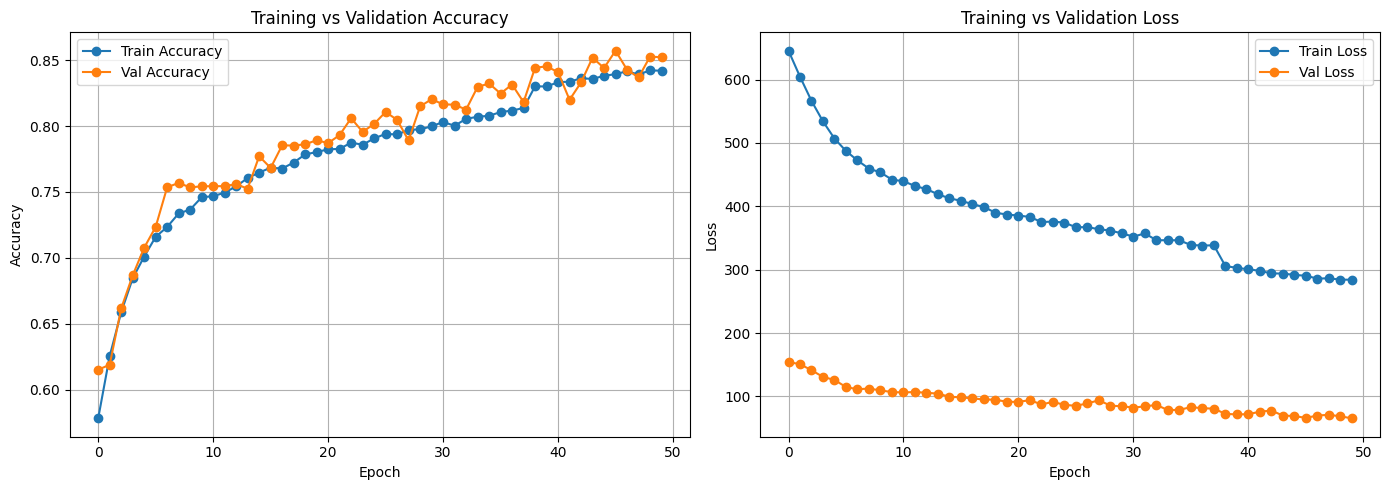

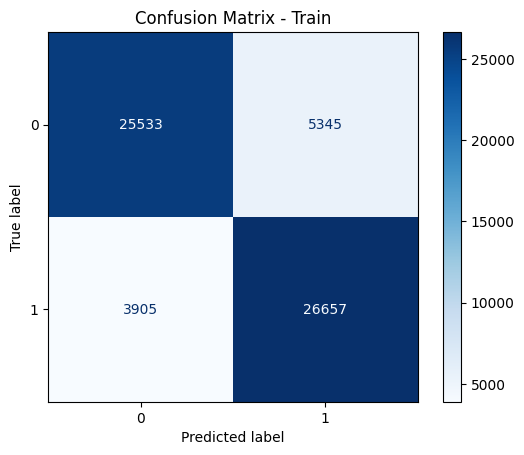

Classification Report - Train:

              precision    recall  f1-score   support

     Class 0       0.87      0.83      0.85     30878
     Class 1       0.83      0.87      0.85     30562

    accuracy                           0.85     61440
   macro avg       0.85      0.85      0.85     61440
weighted avg       0.85      0.85      0.85     61440



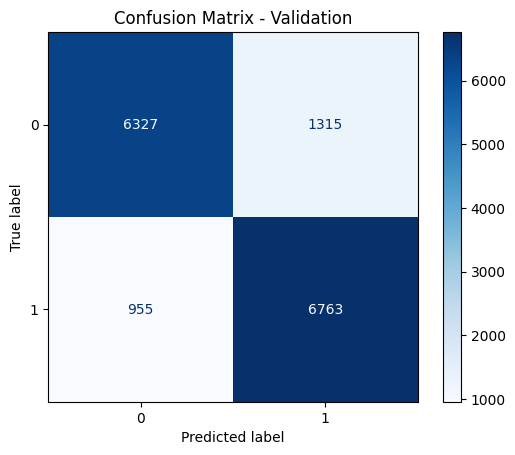

Classification Report - Validation:

              precision    recall  f1-score   support

     Class 0       0.87      0.83      0.85      7642
     Class 1       0.84      0.88      0.86      7718

    accuracy                           0.85     15360
   macro avg       0.85      0.85      0.85     15360
weighted avg       0.85      0.85      0.85     15360



In [5]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- Confusion Matrix & Classification Report (Train) ---
all_preds_train = []
all_labels_train = []

model.eval()
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        all_preds_train.extend(preds.numpy())
        all_labels_train.extend(yb.numpy())

cm_train = confusion_matrix(all_labels_train, all_preds_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1])
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train")
plt.show()

print("Classification Report - Train:\n")
print(classification_report(all_labels_train, all_preds_train, target_names=['Class 0', 'Class 1']))


# --- Confusion Matrix & Classification Report (Validation/Test) ---
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        all_preds_val.extend(preds.numpy())
        all_labels_val.extend(yb.numpy())

cm_val = confusion_matrix(all_labels_val, all_preds_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1])
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation")
plt.show()

print("Classification Report - Validation:\n")
print(classification_report(all_labels_val, all_preds_val, target_names=['Class 0', 'Class 1']))

# hse 3d arousal

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Store training history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


class Complex3DCNN(nn.Module):
    def __init__(self,
                 input_shape=(1, 8, 8, 128),
                 num_classes=2,
                 conv_channels=[32, 64, 128],
                 kernel_size=(3, 3, 7),
                 pool_sizes=[(1, 2, 2), (2, 2, 4), (2, 2, 4)],
                 dropout_rate=0.6,
                 fc_dim=64):
        super(Complex3DCNN, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.pools = nn.ModuleList()

        in_channels = input_shape[0]  # usually 1 for EEG
        for i in range(len(conv_channels)):
            out_channels = conv_channels[i]
            self.convs.append(nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
            self.bns.append(nn.BatchNorm3d(out_channels))
            self.pools.append(nn.MaxPool3d(pool_sizes[i]))
            in_channels = out_channels

        self.dropout = nn.Dropout(dropout_rate)

        # Dummy forward pass to compute the flatten size
        with torch.no_grad():
            dummy_input = torch.zeros((1, *input_shape))
            for conv, bn, pool in zip(self.convs, self.bns, self.pools):
                dummy_input = pool(F.relu(bn(conv(dummy_input))))
            self.flattened_size = dummy_input.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, fc_dim)
        self.fc2 = nn.Linear(fc_dim, num_classes)

    def forward(self, x):
        for conv, bn, pool in zip(self.convs, self.bns, self.pools):
            x = pool(F.relu(bn(conv(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# Convert to torch tensors
import torch
X = torch.tensor(final_hse_input, dtype=torch.float32).unsqueeze(1)  # (76800, 1, 8, 8, 128)
y = torch.tensor(repeated_labels_arousal, dtype=torch.long)

from torch.utils.data import TensorDataset, DataLoader, random_split

# Dataset
dataset = TensorDataset(X, y)

# Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


model = Complex3DCNN(num_classes=2).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

criterion = nn.CrossEntropyLoss()

device = next(model.parameters()).device

for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (preds.argmax(1) == yb).sum().item()
    
    train_acc = train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            val_correct += (preds.argmax(1) == yb).sum().item()
    
    val_acc = val_correct / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f} | Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 615.1210, Train Acc = 0.6324 | Val Loss = 146.2016, Val Acc = 0.6624
Epoch 2: Train Loss = 584.9170, Train Acc = 0.6673 | Val Loss = 141.1597, Val Acc = 0.6910
Epoch 3: Train Loss = 554.5025, Train Acc = 0.6869 | Val Loss = 133.3810, Val Acc = 0.6964
Epoch 4: Train Loss = 529.0181, Train Acc = 0.7046 | Val Loss = 126.2293, Val Acc = 0.7344
Epoch 5: Train Loss = 507.6483, Train Acc = 0.7168 | Val Loss = 121.2596, Val Acc = 0.7391
Epoch 6: Train Loss = 492.4803, Train Acc = 0.7246 | Val Loss = 118.8931, Val Acc = 0.7492
Epoch 7: Train Loss = 471.8153, Train Acc = 0.7361 | Val Loss = 114.8147, Val Acc = 0.7416
Epoch 8: Train Loss = 459.4355, Train Acc = 0.7448 | Val Loss = 105.8157, Val Acc = 0.7648
Epoch 9: Train Loss = 447.9760, Train Acc = 0.7518 | Val Loss = 108.9203, Val Acc = 0.7701
Epoch 10: Train Loss = 439.5106, Train Acc = 0.7565 | Val Loss = 114.8922, Val Acc = 0.7637
Epoch 11: Train Loss = 433.5739, Train Acc = 0.7601 | Val Loss = 107.7999, Val Acc = 0.75

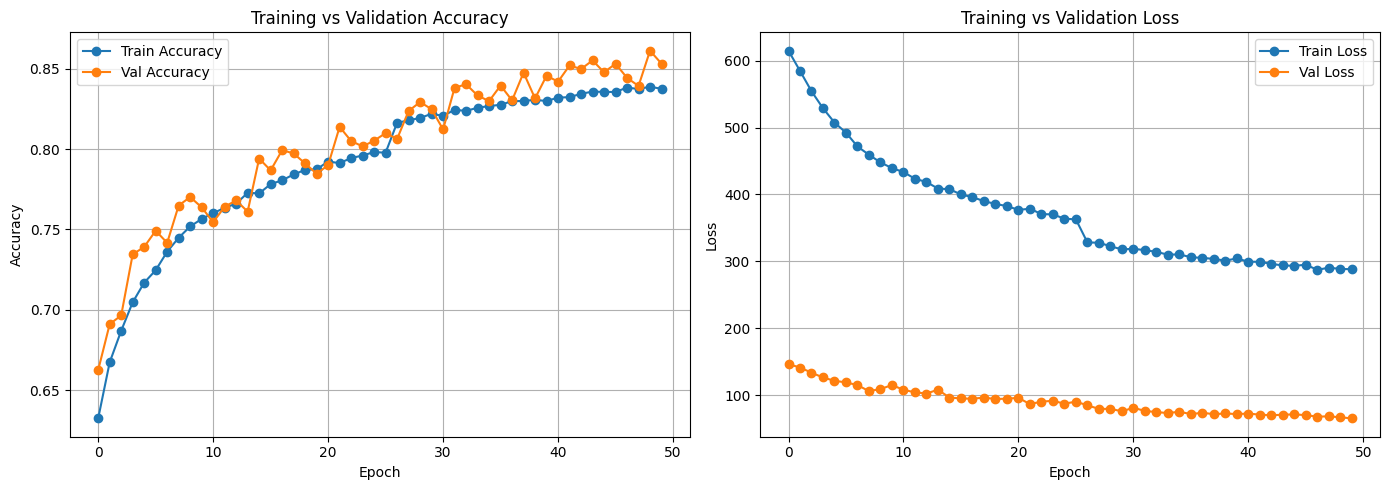

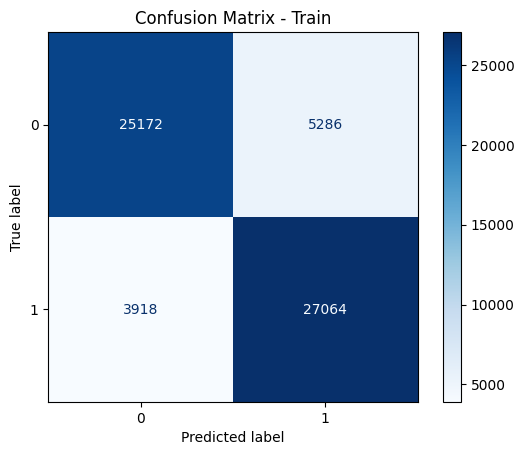

Classification Report - Train:

              precision    recall  f1-score   support

     Class 0       0.87      0.83      0.85     30458
     Class 1       0.84      0.87      0.85     30982

    accuracy                           0.85     61440
   macro avg       0.85      0.85      0.85     61440
weighted avg       0.85      0.85      0.85     61440



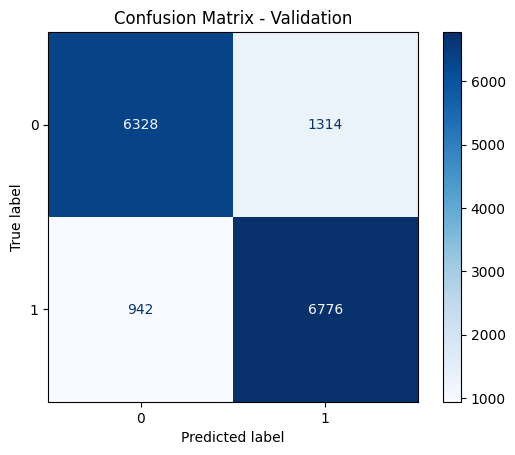

Classification Report - Validation:

              precision    recall  f1-score   support

     Class 0       0.87      0.83      0.85      7642
     Class 1       0.84      0.88      0.86      7718

    accuracy                           0.85     15360
   macro avg       0.85      0.85      0.85     15360
weighted avg       0.85      0.85      0.85     15360



In [7]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- Confusion Matrix & Classification Report (Train) ---
all_preds_train = []
all_labels_train = []

model.eval()
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        all_preds_train.extend(preds.numpy())
        all_labels_train.extend(yb.numpy())

cm_train = confusion_matrix(all_labels_train, all_preds_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1])
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train")
plt.show()

print("Classification Report - Train:\n")
print(classification_report(all_labels_train, all_preds_train, target_names=['Class 0', 'Class 1']))


# --- Confusion Matrix & Classification Report (Validation/Test) ---
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        all_preds_val.extend(preds.numpy())
        all_labels_val.extend(yb.numpy())

cm_val = confusion_matrix(all_labels_val, all_preds_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1])
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation")
plt.show()

print("Classification Report - Validation:\n")
print(classification_report(all_labels_val, all_preds_val, target_names=['Class 0', 'Class 1']))